In [55]:
import h5py
import dxchange
import numpy as np
import torch as tc
import torch.nn.functional as tcf
import tomopy
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [63]:
# Load projections around a certain angle
_, _, _, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=(0, 1))
n_proj_rad = 30
n_skip = 20
i_theta_cen = len(theta) // 2
prj_ind_range = (i_theta_cen - n_skip * n_proj_rad, i_theta_cen + n_skip * n_proj_rad + 1, n_skip)
prj, flt, drk, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=prj_ind_range)
prj = tomopy.normalize(prj, flt, drk)
prj = tomopy.minus_log(prj)
theta_center = theta[i_theta_cen]
this_theta_ls = theta[slice(*prj_ind_range)]
this_theta_ls = this_theta_ls - theta_center
print(this_theta_ls)

# downsample
prj = zoom(prj, [1, 0.25, 0.25])
print(prj.shape)

[-1.25663706 -1.21474916 -1.17286126 -1.13097336 -1.08908545 -1.04719755
 -1.00530965 -0.96342175 -0.92153385 -0.87947141 -0.83775804 -0.79587014
 -0.75398224 -0.71209433 -0.67020643 -0.62831853 -0.58643063 -0.54454273
 -0.50265482 -0.46076692 -0.41887902 -0.37699112 -0.33510322 -0.29321531
 -0.25132741 -0.20943951 -0.16755161 -0.12566371 -0.0837758  -0.0418879
  0.          0.0418879   0.0837758   0.12566371  0.16755161  0.20943951
  0.25132741  0.29321531  0.33510322  0.37699112  0.41887902  0.46076692
  0.50265482  0.54454273  0.58643063  0.62831853  0.67020643  0.71209433
  0.75398224  0.79587014  0.83775804  0.87964594  0.92153385  0.96342175
  1.00530965  1.04719755  1.08908545  1.13097336  1.17286126  1.21474916
  1.25663706]
(61, 448, 512)


In [68]:
def to_numpy(var):
    if var.device.type == 'cpu':
        return var.data.numpy()
    else:
        return var.cpu().data.numpy()

def rescale(x, scale_factor):
    a = tc.tensor([[[1. / scale_factor[1], 0, 0],
                    [0, 1./ scale_factor[0], 0]]])
    a = tcf.affine_grid(a, [1, 1, *prj.shape[1:]])
    x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a.double(), align_corners=True, padding_mode='border')
    return x[0, 0]

In [84]:
def forward(x, h):
    y = tc.zeros_like(x, device=device)
    for i in range(len(this_theta_ls)):
        temp = rescale(x, scale_factor=[1, np.cos(this_theta_ls[i])])
        y = y + temp
    y = y + h
    return y

def get_loss(x, h, y0):
    y = forward(x, h)
    l = tc.mean((y - y0) ** 2) + 1e5 * tc.mean(x ** 2)
    return l

mask = dxchange.read_tiff('transform_fitting/mask.tiff')
device = None
prj_sum = np.sum(prj, axis=0)
prj_sum = tc.tensor(prj_sum, requires_grad=False, device=device)
x = np.random.normal(loc=0.5 / prj.shape[-1], scale=0.05 / prj.shape[-1], size=prj.shape[1:])
x = np.clip(x, 0, None)
x = x * mask
x = tc.tensor(x, device=device, requires_grad=True)
h = tc.normal(mean=tc.full(prj.shape[1:], 0.5), std=tc.full(prj.shape[1:], 0.05))
h = h * mask
h = tc.tensor(h, requires_grad=True, device=device)
opt = tc.optim.Adam([x, h], 4e-3)

for i_epoch in range(1000):
    opt.zero_grad()
    loss = get_loss(x, h, prj_sum)
    loss.backward()
    opt.step()
    if (i_epoch + 1) % 10 == 0:
        print('{}: {}'.format(i_epoch, to_numpy(loss)))
x_rec = to_numpy(x)
h_rec = to_numpy(h)
y_final = forward(x, h)
y_final = to_numpy(y_final)

/home/beams/B282788/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


9: 452.6230719095191
19: 448.24940045824275
29: 446.04320104477205
39: 444.52479177532894
49: 443.1572731579516
59: 441.82163248902486
69: 440.50581158687135
79: 439.2032545644898
89: 437.9078972944115
99: 436.6171819515263
109: 435.3309055591526
119: 434.04890144831603
129: 432.7710021419055
139: 431.49713727782324
149: 430.22725739488425
159: 428.96131957932215
169: 427.69928627374605
179: 426.4411231359456
189: 425.18679772200477
199: 423.93627906923734
209: 422.6895372646471
219: 421.4465435736616
229: 420.20727008276054
239: 418.97168959356645
249: 417.7397756264186
259: 416.51150233855793
269: 415.2868444579954
279: 414.06577726895216
289: 412.84827648003187
299: 411.6343183081158
309: 410.4238793702352
319: 409.2169367376679
329: 408.0134678943945
339: 406.81345070671756
349: 405.61686335542305
359: 404.42368443993524
369: 403.23389285833167
379: 402.04746781915685
389: 400.86438891545475
399: 399.684635941652
409: 398.5081891108919
419: 397.33502881846624
429: 396.1651357948477

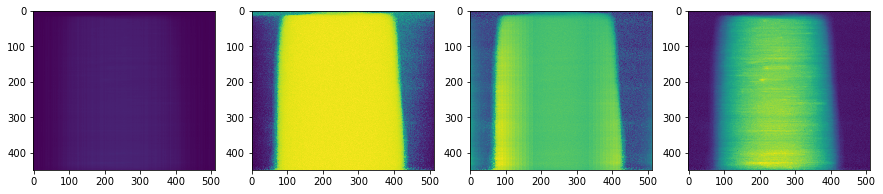

In [85]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(x_rec)
axes[1].imshow(h_rec)
axes[2].imshow(y_final)
axes[3].imshow(to_numpy(prj_sum))
plt.show()
dxchange.write_tiff(x_rec, 'transform_fitting/x_rec', dtype='float32', overwrite=True)
dxchange.write_tiff(h_rec, 'transform_fitting/h_rec', dtype='float32', overwrite=True)
dxchange.write_tiff(y_final, 'transform_fitting/y_final', dtype='float32', overwrite=True)
dxchange.write_tiff(to_numpy(prj_sum), 'transform_fitting/prj_sum', dtype='float32', overwrite=True)

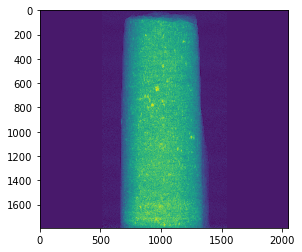

In [32]:
# g = prj[0]
# g = tc.tensor(g, requires_grad=False)
# a = tc.tensor([[[1 / 0.5, 0, 0],
#                 [0, 1., 0]]])
# a = tcf.affine_grid(a, [1, 1, *prj.shape[1:]])
# gg = tcf.grid_sample(g.reshape([1, 1, *g.shape]), a, align_corners=True)
# #gg = tcf.interpolate(g.reshape([1, 1, *g.shape]), size=prj.shape[1:], scale_factor=[1, 0.5], mode='bilinear')
# gg = to_numpy(gg[0, 0])
# plt.imshow(gg)
# plt.show()